# Lab. 7 - K-Means and the LLoyd algorithm

In this lab we consider the problem of **unsupervised learning**, through one of the most famous **clustering** algorithms: K-means.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.linalg as la
import scipy.spatial

In [5]:
'''
	- `means`: List of mean vectors for each Gaussian distribution.
	- `sigmas`: List of standard deviations for each Gaussian distribution.
			standard deviations = a quantity expressing by how much the members of a group differ from the mean value for the group.
	- `n`: Number of samples to be generated for each Gaussian distribution.
'''
# Function to generate synthetic data for a mixture of Gaussians
def mixGauss(means, sigmas, n):
    # Convert means and sigmas to NumPy arrays
    means = np.array(means)
    sigmas = np.array(sigmas)

    # Determine the dimensionality based on the number of features in means
    d = means.shape[1]
    # Get the number of classes (Gaussians)
    num_classes = sigmas.size

    # Initialize arrays for data and labels
		# Initalize with np.inf value
		# n * num_classes = rows, d = columns 
    data = np.full((n * num_classes, d), np.inf)
    # Initialize labels (y) with zeros 
    # n * num_classes = rows, 1 column (not mentioned)
    labels = np.zeros(n * num_classes)

    # Generate data points for each Gaussian distribution
    # enuerate [1,2,3] => [[0,1],[1,2],[2,3]] -> each value contains index
    for idx, sigma in enumerate(sigmas):
        # Generate n samples from a multivariate normal distribution
        '''
        random.multivariate_normal(mean, cov, size=None, check_valid='warn', tol=1e-8)
        Draw random samples from a multivariate normal distribution.
        '''
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        # Assign labels based on the index of the Gaussian distribution
            # label[idx:idx+1] means only one element
            # ???
        labels[idx * n:(idx + 1) * n] = idx 
        
    # If there are only two classes, convert labels to binary values (-1 and 1)
    if num_classes == 2:
        # Any element of the labels with zero value converted into -1 
            # Instead of having 0,1, we have -1,1
        labels[labels == 0] = -1

    # Return the generated data and labels
    return data, labels

In [7]:
# Function to compute all pairwise squared Euclidean distances between two matrices
def all_distances(X1, X2):
    # Use scipy to compute pairwise squared Euclidean distances
    return scipy.spatial.distance.cdist(X1, X2, metric='sqeuclidean')

## Part 1. Implementing the LLoyd Algorithm

The Lloyd algorithm is the standard algorithm for implementing k-means. It is based on two steps
 1. Assigning each point to a cluster
 2. Updating the cluster centers
repeated iteratively until the cluster centers (and point assignments) have converged.

The function skeleton below takes as input the following arguments
 - `X` the data matrix
 - `centers` the initial cluster centers. This could be random, or as we will see in the second part, they could be initialized following a smarter strategy.
 - `maxiter` the maximum number of iterations of the algorithm.
 
The function returns
 - the final cluster centers
 - the assignment labels of each point to their cluster.

In [10]:
def lloyd(X, centers, maxiter):
		# maxiter = the number of iterations 
    # X: n x d, where n is the number of data points and d is the number of features
    # centers: k x d, where k is the number of clusters, k = the number of coluns
		# n = rows, d = columns
    n, d = X.shape
		# k = the number of clusters
    k = centers.shape[0]
    
    # Iterate for a maximum number of iterations
    for i in range(maxiter):
        # Compute Squared Euclidean distance (i.e., the squared distance)
        # between each cluster center and each observation
        # Compute the squared Euclidean distance between each data point and each cluster center.
        '''
            1. **`X[:, np.newaxis, :]`**:
        - This part involves array broadcasting. The `np.newaxis` is used to add a new axis to the `X` array. If `X` is a 2D array (matrix) with shape `(n, d)`, then after adding a new axis, it becomes a 3D array with shape `(n, 1, d)`.
            - This adds a new axis in the second position of X, transforming it from a 2D array with shape (n, d) to a 3D array with shape (n, 1, d). This new axis is introduced to facilitate broadcasting.
            - new axis contains ones values
        '''
        '''
        Suppose you have two arrays:
            - `X`: Shape `(n, 1, d)`
            - `centers`: Shape `(k, d)`
            1. **Dimension Alignment**:
                - The dimensions are compared from the right. `X` has three dimensions, and `centers` has two. To make them compatible, the dimensions of `centers` are padded with ones on the left: `(1, k, d)`.
            2. **Broadcasting**:
                - The arrays are broadcasted along each dimension. In dimensions where one array has size 1 and the other has a size greater than 1, the array with size 1 is stretched to match the size of the other array.
                - After broadcasting, `X` becomes an array of shape `(n, k, d)`.
            3. **Element-Wise Operation**:
                - Now, the arrays have compatible shapes for element-wise operations. The subtraction and squaring are performed element-wise, resulting in an array of shape `(n, k, d)`.
        '''
        # np.newaxis is appended just to compatibility for size for calculation
        dist = np.sum((X[:, np.newaxis, :] - centers) ** 2, axis=-1)
        
        # Assign data to clusters: 
        # For each point, find the closest center in terms of Euclidean distance
        c_asg = np.argmin(dist, axis=1)

        # Update cluster center
        for c in range(k):
            # Compute the mean of the data points assigned to the current cluster
            centers[c] = np.mean(X[c_asg == c], axis=0)
        
    # Return the final cluster assignments and centers
    return c_asg, centers

## Part 2. K-Means: Analysis

Here you should create a synthetic dataset using the `mixGauss` function **with four or more classes**.

You can experiment with different dataset creation strategies:
 - Create datasets where the classes are very well separated, then k-means should be able to infer the classes easily
 - Create datasets where the classes have overlap. In this case the k-means algorithm won't be able to distinguish the points of overlap. What do you think will happen?
 
Then, you should run the k-means algorithm with randomly initialized centers:
 1. Create the random centers **within the same range as your data**. You can use the `np.random.uniform` function for this.
 2. Run the Lloyd algorithm
 3. Plot the results.

##### Your Tasks
You should repeat this procedure multiple times, and comment on the following:
 1. Do you obtain the same clusters every time?
     If you obtain clusterings which are always the same, you can try to initialize two cluster centers at a very similar point. This will put the algorithm in a difficult situation!
     
 2. Why do the colors of a specific cluster seem to change at each iteration?
 3. Try using the *wrong* number of clusters `k` (wrong with respect to the number of classes you used to generate the data). What happens?

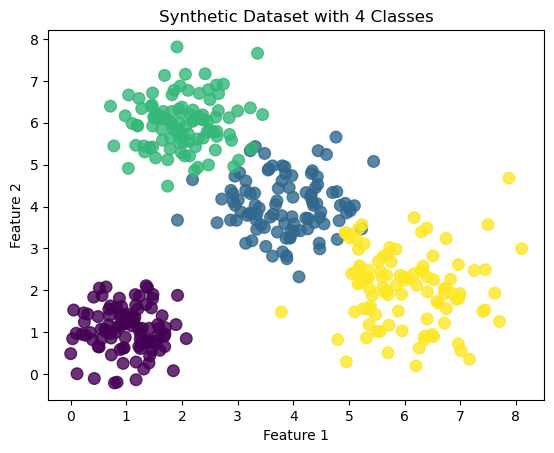

In [13]:
# Build a dataset with at least 4 classes in 2 dimensions
X, Y = mixGauss(
    means=[[1, 1], [4, 4], [2, 6], [6, 2]],  # Adjust the mean coordinates for each class
    sigmas=[0.5, 0.7, 0.6, 0.8],  # Adjust the standard deviations for each class
    n=100  # Number of samples per class
)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], s=70, c=Y, alpha=0.8)
plt.title("Synthetic Dataset with 4 Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Centers: [[2.74582962 4.25422537]
 [7.69126208 3.80974094]
 [3.69174239 7.34771665]
 [7.22158964 4.50982045]]


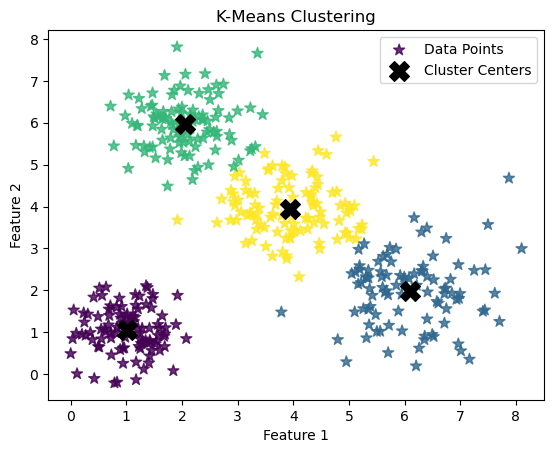

In [15]:
# Try with a random initialization of the centers.
k = 4  # Number of clusters, adjust as needed
centers0 = np.random.uniform(low=np.amin(X, 0), high=np.amax(X, 0), size=(k, X.shape[1]))
print('Centers: {}'.format(centers0))

# Call the Lloyd algorithm function
Iv, centers = lloyd(X, centers0, maxiter=100)

# Visualize the final clusters and their centroids
plt.scatter(X[:, 0], X[:, 1], s=70, c=Iv, marker='*', alpha=0.8, label="Data Points")
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='k', marker='X', label="Cluster Centers")
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## Part 3. A Better Initialization Strategy: K-Means++

Initializing the cluster centers at random, sometimes makes the algorithm converge to a sub-optimal local minimum.

The k-means++ algorithm is an **initialization strategy** to generate the initial centers, which can then be passed to the lloyd algorithm.

K-means++ works by selecting the cluster centers as the points within the dataset which have the **maximum distance** between each other. To do this it uses a greedy strategy implemented in the `kmeanspp` function below.

Take a look at the K-Means++ function and then use it as initialization for the K-means algorithm.

##### Your task:
You should take a dataset on which K-Means was struggling, and apply K-Means++ for the center initialization, trying to show that the new initialization strategy improves the clustering algorithm.

In [20]:
# check the numeric example in the expalanation
def kmeanspp(X, k):
    n, d = X.shape

    # A random index generation (only one)
    ''' IdxC = np.random.permutation(10)
        >>> IdxC
        array([3, 7, 5, 2, 0, 8, 4, 9, 1, 6])
    '''
    IdxC = np.random.permutation(n)
    centers = np.zeros((k, d))
    ''' 
    for k = 2
    centers = 
        [[0, 0],
        [0, 0]]
    '''
    # Select a random point in the dataset as the starting point
    # Assign the random point to the first element of centers array
        # means centers[0]
    # Permutation is place movement
    # Ceneters is actually X we obtain the distance of all elements of X from each element of x for instance [[1,2],[4,5],[6,7]]
    # one time [1,2] as the center from three [[1,2],[4,5],[6,7]]
    # second time [4,5] as the center from three [[1,2],[4,5],[6,7]]
    # The first value of IdxC is assigned to the centers[0]
        # IdxC is generated randomly 
    centers[0, :] = X[IdxC[0], :]
    '''
        >>> centers (just an example)
        array([[1., 2.],
               [0., 0.]])
    '''
    
    for i in range(1, k):
        # Distance calculation between centers and X
        '''
            all_distances(centers[:i, :], X): Calculates the distances between each point in the dataset (X) and each of the existing centers up to the (i-1)th center. The resulting matrix D contains these distances.
        '''
        '''
            X = np.array([[1, 2], [5, 4], [9, 7]])
            D = [[ 0, 20, 98],   # Squared distances to [1, 2]
                [16,  0, 26]]   # Squared distances to [5, 4]
        '''
        D = all_distances(centers[:i, :], X)
    
        '''
            min(0,16) = 0
            min(20,0) = 0
            min(98,26) = 26
        '''
        # Ds would be [0, 0, 26].
        Ds = np.min(D, axis=0)  # This is the distance to the closest existing center
				
        # Probability of choosing new points as centers is weighted as the 
        # squared distance to the closest existing center.
				# Square the minimum distances
				# Ds would be [0, 0, 676]
        D2 = Ds ** 2
				
        '''
            >>> x1 = np.arange(9.0).reshape((3, 3))
            >>> x1
            array([[0., 1., 2.],
                   [3., 4., 5.],
                   [6., 7., 8.]])

            >>> x2 = np.arange(3.0)
            >>> x2

                array([0., 1., 2.])
            >>> np.divide(x1, x2)

                array([[nan, 1. , 1. ],
                   [inf, 4. , 2.5],
                   [inf, 7. , 4. ]])]5
                The devision is occurd for instane 0/0 = nan
                    1/1 = 1, 2/2 = 1, 3/0 = inf, ...
        '''
        # Probability Calculation
        '''
            np.divide(D2, np.sum(D2)): Normalizing the squared distances to obtain probabilities. This step ensures that points farther from existing centers have lower probabilities.
        '''

        # Calculate probabilities based on squared distances
        # P = [0/676, 0/676, 676/676] = [0, 0, 1]
        P = np.divide(D2, np.sum(D2))
        
        # Simply pick the point with the highest probability
				# Based on probability not value 
				# Choose the new center probabilistically
				# newcpos = the index of max[0, 0, 1] is 2
        newcpos = np.argmax(P)

				# Assign the new center
				# x[2] is assigned the the centers[i] as the new center
        centers[i, :] = X[newcpos, :]
    return centers

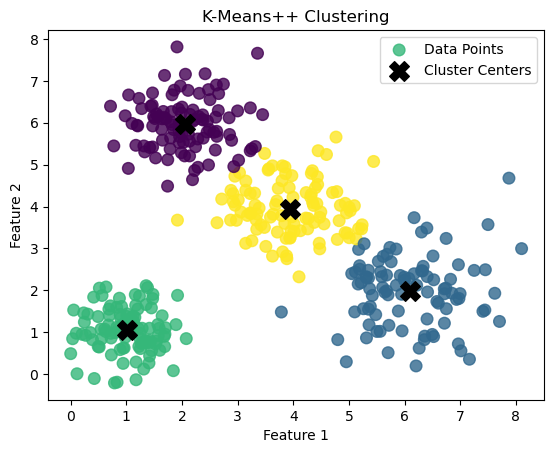

In [21]:
# Try and use K-Means++ for initialization
k = 4  # Number of clusters, adjust as needed
centers0 = kmeanspp(X, k)

# Call the Lloyd algorithm function
Iv, centers = lloyd(X, centers0, maxiter=100)

# Visualize the final clusters and their centroids
plt.scatter(X[:, 0], X[:, 1], s=70, c=Iv, alpha=0.8, label="Data Points")
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='k', marker='X', label="Cluster Centers")
plt.title("K-Means++ Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()